In [1]:
from requests_ratelimiter import LimiterSession as Session
import json
import pandas as pd
import ast
import datetime as dt
import plotly.express as px

## Storing and Loading Data

In [ ]:
# Storing from previous fetches
df_downloads.to_feather("total_podcast_downloads.feather")
df.to_feather("tbp_episodic_downloads.feather")
df_hio.to_feather("hio_episodic_downloads.feather")

In [2]:
# Loading from already stored feather
df_downloads = pd.read_feather("total_podcast_downloads.feather")
df = pd.read_feather("tbp_episodic_downloads.feather")
df_hio = pd.read_feather("hio_episodic_downloads.feather")

## Getting initial podcast and episode info from Simplecast

In [4]:
# Setting up session to be used
### NOTE: Simplecast API has a rate limit of 100 requests per minute. The use of the the Session should be set to this
bearer = 'eyJhcGlfa2V5IjoiOTQ1YjhkZjViNDY5MjNlM2ZkZjE2NDJjMWI5ZDE2MmQifQ==' # Corey's key
# bearer = 'eyJhcGlfa2V5IjoiYzAxMzg3ODhhNmYzOWFmYjQ0MmYxNTFmOWIzMzg1OTIifQ==' # Jessie's key (Doesn't seem to work)

session = Session(per_minute=100)
session.headers = {'authorization':'Bearer {}'.format(bearer)}

In [78]:
r = session.get('https://api.simplecast.com/podcasts')
podcasts = json.loads(r.text)

In [79]:
podcast_ids = []
for podcast in podcasts['collection']:
    podcast_ids.append({"title": podcast['title'], "id" : podcast['id']})

In [80]:
podcast_details = []
for podcast in podcast_ids:
    r = session.get('https://api.simplecast.com/podcasts/{}'.format(podcast["id"]))
    res_podcast = json.loads(r.text)
    podcast_details.append(res_podcast)

## Get General Podcast Download Analytics
#### Updated 2023-01-30 1:00 PM EST

In [83]:
# Define a bunch of useful functions to be used when extracting info from JSON into DataFrames
def return_id(json_str):
    return json_str['id']

def return_downloads(json_str):
    return json_str['total']

def return_pubdate(json_str):
    return json_str['feeds']['collection'][0]['published_at']

def get_show(title):
    if "Hashing" in title:
        return "HIO"
    elif "HIO" in title:
        return "HIO"
    else:
        return "TBPN"

In [81]:
podcast_analytics = []
for podcast in podcast_ids:
    r = session.get('https://api.simplecast.com/analytics/downloads?podcast={}'.format(podcast["id"]))
    res_podcast = json.loads(r.text)
    podcast_analytics.append({"show": podcast['title'], "analytics": res_podcast})

In [84]:
df_downloads = pd.DataFrame(podcast_analytics)

In [6]:
df_downloads

,show,analytics,id,total_downloads
0,Hashing It Out,{'by_interval': [{'downloads_percent': 0.08178...,b54c0885-7c72-415d-b032-7d294b78d785,269
1,The Bitcoin Podcast,"{'by_interval': [{'downloads_percent': 0.0, 'd...",b623b331-ffef-40c4-918d-b35a07ee8729,2063387


In [88]:
df_downloads['id'] = df_downloads['analytics'].apply(return_id).copy()
df_downloads['total_downloads'] = df_downloads['analytics'].apply(return_downloads).copy()

## Get HIO ids and associated download data
#### Updated 2023-01-30 1:00 PM EST

In [32]:
session = requests.Session()
session.headers.update({'authorization':'Bearer {}'.format(bearer)})

def get_jobs():
    url = "https://api.simplecast.com/podcasts/{}/episodes".format(podcast_ids[0]['id'] )
    first_page = session.get(url).json()
    yield first_page
        
    while first_page['pages']['next'] != None:
        first_page = session.get(first_page['pages']['next']['href']).json()
        yield first_page

pages = [page for page in get_jobs()]

In [33]:
hio_episode_ids = []
for page in pages:
    for episode in page['collection']:
        hio_episode_ids.append({"title": episode['title'], 'id': episode['id']})

In [68]:
for episode in hio_episode_ids:
    url = "https://api.simplecast.com/analytics/downloads?episode={}".format(episode['id'])
    episode_json = session.get(url).json()
    hio_episodic_downloads.append({"title": episode['title'], "downloads":episode_json})
                                                                             

In [69]:
df_hio = pd.DataFrame(hio_episodic_downloads)
df_hio['id'] = df_hio['downloads'].apply(return_id).copy()
df_hio['total_downloads'] = df_hio['downloads'].apply(return_downloads).copy()
df_hio['published_at'] = df_hio['downloads'].apply(return_pubdate).copy()
df_hio['show'] = df_hio['title'].apply(get_show).copy()
df_hio = df_hio.drop_duplicates(subset=['id'])

## Get TBP Episodic ids and associated downloads data
#### Updated 2023-01-30 1:00 PM EST

In [98]:
session = requests.Session()

def get_jobs():
    url = "https://api.simplecast.com/podcasts/{}/episodes".format(podcast_ids[1]['id'] )
    first_page = session.get(url).json()
    yield first_page
        
    while first_page['pages']['next'] != None:
        first_page = session.get(first_page['pages']['next']['href'], headers={'authorization':'Bearer {}'.format(bearer)}).json()
        yield first_page

pages = [page for page in get_jobs()]

In [99]:
tbp_episode_ids = []
for page in pages:
    for episode in page['collection']:
        tbp_episode_ids.append({"title": episode['title'], 'id': episode['id']})

In [101]:
session = requests.Session()

tbp_episodic_downloads = []
for episode in tbp_episode_ids:
    url = "https://api.simplecast.com/analytics/downloads?episode={}".format(episode['id'])
    episode_json = session.get(url, headers={'authorization':'Bearer {}'.format(bearer)}).json()
    tbp_episodic_downloads.append({"title": episode['title'], "downloads":episode_json})

In [6]:
df = pd.DataFrame(tbp_episodic_downloads)
df['id'] = df['downloads'].apply(return_id).copy()
df['total_downloads'] = df['downloads'].apply(return_downloads).copy()
df['published_at'] = df['downloads'].apply(return_pubdate).copy()
df['show'] = df['title'].apply(get_show).copy()
df = df.drop_duplicates(subset=['id'])

## Print out some Stats

In [3]:
hio_total_downloads = df[df['show'] == 'HIO'].total_downloads.sum()
hio_num_shows = len(df[df['show'] == 'HIO'].total_downloads)

tbp_total_downloads = df[df['show'] == 'TBPN'].total_downloads.sum()
tbp_num_shows = len(df[df['show'] == 'TBPN'].total_downloads)


print("HIO has {} downloads over {} shows for and average of {} downloads/show".format(hio_total_downloads, hio_num_shows, hio_total_downloads/hio_num_shows))
print("TBP has {} downloads over {} shows for and average of {} downloads/show".format(tbp_total_downloads, tbp_num_shows, tbp_total_downloads/tbp_num_shows))

HIO has 330444 downloads over 118 shows for and average of 2800.3728813559323 downloads/show
TBP has 1728937 downloads over 891 shows for and average of 1940.4455667789 downloads/show


In [31]:
df.downloads.values[0]

{'by_interval': array([{'downloads_percent': 0.52188, 'downloads_total': 489, 'interval': '2023-01-24'},
        {'downloads_percent': 0.21131, 'downloads_total': 198, 'interval': '2023-01-25'},
        {'downloads_percent': 0.09712, 'downloads_total': 91, 'interval': '2023-01-26'},
        {'downloads_percent': 0.07044, 'downloads_total': 66, 'interval': '2023-01-27'},
        {'downloads_percent': 0.0555, 'downloads_total': 52, 'interval': '2023-01-28'},
        {'downloads_percent': 0.04376, 'downloads_total': 41, 'interval': '2023-01-29'}],
       dtype=object),
 'feeds': {'collection': array([{'id': '3aa77255-8f97-4da1-97fa-d9a1c6f73850', 'is_primary': True, 'name': 'Default', 'published_at': '2023-01-24T17:00:00Z', 'scheduled_for': None, 'status': 'published'}],
        dtype=object)},
 'href': 'https://api.simplecast.com/analytics/downloads?episode=7a6f11df-51a1-4812-bc18-a49c33a95ea4',
 'id': '7a6f11df-51a1-4812-bc18-a49c33a95ea4',
 'interval': 'day',
 'total': 937}

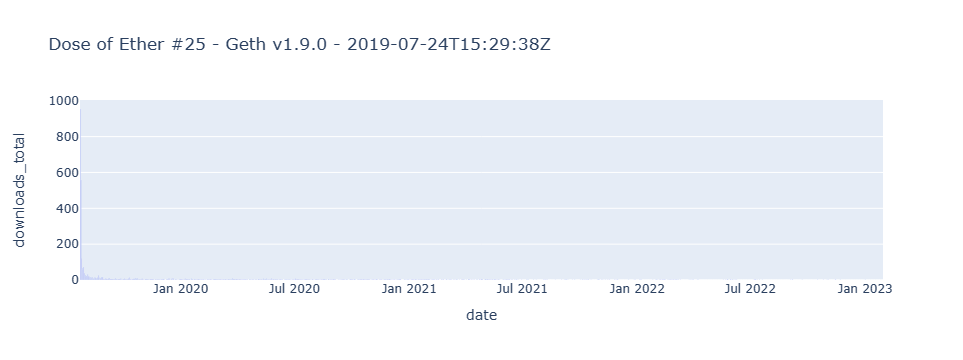

In [41]:
ep_index = 301
test = pd.DataFrame([dic for dic in df.downloads.values[ep_index]['by_interval']])
test['date'] = pd.to_datetime(test['interval'], infer_datetime_format=True)
fig = px.bar(test, y="downloads_total", x='date', title=df.title.values[ep_index] + ' - ' + df.downloads.values[ep_index]['feeds']['collection'][0]['published_at'])
fig.show()